## Project
We have collected gene expression levels for $4654$ genes on $184$ early-stage breast cancer samples: **xtrain.txt** (each row is a gene, each column a sample). After surgical removal of the tumour, some unfortunately relapsed within $5$ years (label=$+1$), while other did not (label=$-1$). The labels of the the $184$ samples are available in the file **ytrain.txt**.

- Propose and test different techniques to predict the relapse from gene expression data. Check the effect of parameters, estimate the performance.
- Make a prediction of relapse for the following $92$ samples: **xtest.txt**.

In [0]:
# import library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm as cm


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm  import SVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression

import time
from sklearn import metrics 
from IPython.display import Image, display
np.random.seed(7)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### load data

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ytrain.txt to ytrain.txt
Saving xtrain.txt to xtrain.txt
Saving xtest.txt to xtest.txt
User uploaded file "ytrain.txt" with length 486 bytes
User uploaded file "xtrain.txt" with length 5182112 bytes
User uploaded file "xtest.txt" with length 2613104 bytes


### load data

In [0]:
def loadData(file):
    data = pd.read_csv(file, sep="\t", header=None)
    return data

In [0]:
#load data
xtrain = loadData('xtrain.txt').T
xtest = loadData('xtest.txt').T
ytrain = loadData('ytrain.txt').values.flatten()

# take first row as columns names
header1 = xtrain.iloc[0]
xtrain = xtrain[1:]
xtrain = xtrain.rename(columns = header1)

header2 = xtest.iloc[0]
xtest = xtest[1:]
xtest = xtest.rename(columns = header2)


In [6]:
xtrain.shape, ytrain.shape

((184, 4654), (184,))

In [7]:
negatif = 0
positif = 0
for i in range(len(ytrain)):
    if ytrain[i] == -1:
        negatif += 1
    else:
        positif += 1
print(negatif, positif)

118 66


In [8]:
xtrain.head()

,x10006_at,x10007_at,x100129361_at,x100130449_at,x100130633_at,x100133941_at,x10014_at,x10016_at,x100188893_at,x10019_at,...,x9976_at,x9978_at,x997_at,x9984_at,x9987_at,x9988_at,x9989_at,x9994_at,x9997_at,x9_at
1,8.44,7.84,9.23,2.2,4.93,10.31,7.85,9.91,11.37,3.48,...,7.71,11.32,6.37,8.63,8.61,7.42,8.79,4.7,7.23,8.28
2,7.93,8.47,7.77,2.48,6.7,11.03,3.33,9.53,10.91,4.28,...,9.98,10.4,5.96,7.61,9.51,8.2,9.27,4.7,6.7,12.78
3,7.53,7.49,9.49,5.66,5.99,8.87,3.48,8.02,10.73,4.07,...,8.34,10.57,6.92,8.2,8.71,8.56,8.9,4.7,7.7,12.22
4,7.72,8.38,8.03,5.22,6.95,2.73,4.06,9.26,10.9,7.4,...,9.05,10.92,5.73,8.44,9.18,7.86,9.3,5.58,7.95,12.18
5,7.89,7.75,6.99,2.2,7.06,11.38,3.65,9.22,10.37,3.89,...,9.16,10.73,7.45,7.79,9.15,7.97,8.5,4.7,6.63,12.12


In [9]:
xtest.head()

,x10006_at,x10007_at,x100129361_at,x100130449_at,x100130633_at,x100133941_at,x10014_at,x10016_at,x100188893_at,x10019_at,...,x9976_at,x9978_at,x997_at,x9984_at,x9987_at,x9988_at,x9989_at,x9994_at,x9997_at,x9_at
1,8.54,7.76,8.08,2.2,7.23,10.07,4.16,9.77,10.7,5.35,...,9.44,11.18,6.65,7.92,9.32,8.48,8.51,4.01,7.91,9.46
2,8.13,8.18,7.68,2.2,7.11,8.91,5.05,8.8,10.64,4.86,...,8.51,11.31,5.76,7.43,10.39,8.23,9.49,4.7,7.14,7.02
3,7.94,8.26,7.37,2.2,6.98,11.81,4.16,10.07,10.64,4.3,...,8.4,10.2,5.35,8.42,9.44,7.87,8.64,4.78,6.13,10.57
4,8.7,8.08,8.27,2.2,7.45,7.9,5,8.66,10.41,5.07,...,8.9,10.77,6.6,7.8,9.39,8.74,9.61,5.13,6.73,5.31
5,8.97,8.2,8.87,2.2,6.98,11.49,3.47,9.97,11.63,4.65,...,9.15,11.9,7.34,8.26,8.81,8.12,9.93,7.07,6.84,3


In [10]:
np.all(xtrain.columns == xtest.columns)

True

In [11]:
xtrain.describe()

,x10006_at,x10007_at,x100129361_at,x100130449_at,x100130633_at,x100133941_at,x10014_at,x10016_at,x100188893_at,x10019_at,...,x9976_at,x9978_at,x997_at,x9984_at,x9987_at,x9988_at,x9989_at,x9994_at,x9997_at,x9_at
count,184.00,184.00,184.00,184.0,184.00,184.00,184.00,184.00,184.00,184.00,...,184.00,184.00,184.00,184.00,184.00,184.00,184.00,184.0,184.00,184.0
unique,121.00,111.00,137.00,61.0,128.00,148.00,117.00,126.00,110.00,125.00,...,148.00,121.00,136.00,127.00,114.00,125.00,129.00,74.0,137.00,144.0
top,7.79,8.21,8.23,2.2,6.97,11.03,3.68,9.22,10.74,4.28,...,9.72,11.34,5.76,7.87,9.78,8.18,8.86,4.7,7.38,3.0
freq,13.00,6.00,5.00,105.0,9.00,5.00,5.00,4.00,4.00,14.00,...,3.00,4.00,19.00,5.00,4.00,4.00,4.00,49.0,10.00,29.0


### Features Selection

In [0]:
names = xtrain.columns.values
rfc = RandomForestClassifier()
rfc.fit(xtrain, ytrain)
importances = []
nameslist = []
for name, importance in zip(names, rfc.feature_importances_):
    if importance != 0.0:
        importances.append(importance)
        nameslist.append(name)
        
#features = iris['feature_names']
# importances = rf.feature_importances_
# indices = np.argsort(importances)

In [0]:
x_train = xtrain[nameslist]

In [14]:
featuresImportances = pd.DataFrame(importances, index=nameslist, 
                              columns=["Importance"])
featuresImportances = featuresImportances.sort_values(by=['Importance'], ascending=False)
featuresImportances

,Importance
x22872_at,0.016532
x54407_at,0.016301
x115353_at,0.015722
x4357_at,0.015490
x25844_at,0.014718
x29937_at,0.014599
x55160_at,0.014532
x28962_at,0.014409
x55167_at,0.014024
x22820_at,0.013997


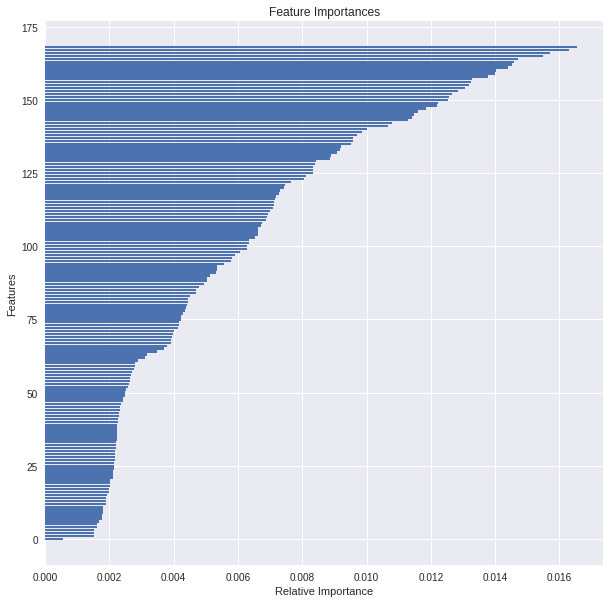

In [15]:
nameslist = np.array(nameslist)
importances.sort()
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(importances)), importances, align='center')
#plt.yticks(range(len(nameslist)), [nameslist[i] for i in range(len(nameslist))])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

### Lasso features selection

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Features reduced from       4654 to        211


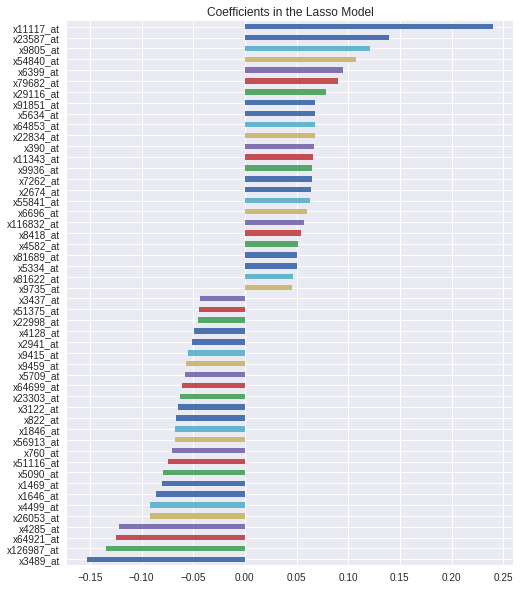

In [16]:
from sklearn.linear_model import Lasso
x_train = np.array(xtrain)
lass = Lasso(
        max_iter=10000,
        alpha= 0.000281,
        random_state= 5 
        )
lass.fit(xtrain,ytrain)
lass.coef_.min(), lass.coef_.max()
#Checking Features Importances
import matplotlib
coef = pd.Series(lass.coef_, index = xtrain.columns)
#print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


imp_coef = pd.concat([coef.sort_values().head(25),
                     coef.sort_values().tail(25)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# Selection of features
good_features = np.abs(np.array(lass.coef_)) > 0

print("Features reduced from %10d to %10d" % (x_train.shape[1], int(good_features.sum())))
#saving data
train_lasso_select = xtrain.iloc[:, good_features]
test_lasso_select= xtest.iloc[:, good_features]
train_lasso_select.to_csv('train_lasso_select.csv',index=False)
test_lasso_select.to_csv('test_lasso_select.csv',index=False)

In [0]:
xtrain_lasso = xtrain.T[good_features].T

In [0]:
xtest_lasso = xtest.T[good_features].T

### split data

In [0]:
Xtrain,Xtest, Ytrain, Ytest = train_test_split(xtrain_lasso, ytrain,test_size=0.3)
Xtrain,Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain,test_size=0.15 )

In [20]:
Xtrain.shape, Xval.shape, Xtest.shape, xtest.shape

((108, 211), (20, 211), (56, 211), (92, 4654))

### Plot Area Under Curve

In [0]:
def plot_roc(model, parameters, y_true):
    """
    Arguments:
    model - trained model .
    parameters - array-like or sparse matrix of shape  [n_samples, n_features]. The input samples. 
    y_true - True binary labels in range {0, 1} or {-1, 1}. If labels are not binary, pos_label should be explicitly given.
    """
    if model is None:
        return 0., 0., np.array([])
    
    predicted = model.predict_proba(parameters)[:,1]
    threshold = 0.5
    predicted_binary = (predicted > threshold).astype(int)
    
    fpr, tpr, threshold = metrics.roc_curve(y_true, predicted, pos_label=1)

    roc_auc = metrics.auc(fpr, tpr) 
    ks = np.max(tpr - fpr) # Kolmogorov-Smirnov test

#     print('ROC_auc = ', roc_auc)
#     print('KS_test = ', ks)
    print('AUC score: %f ' % metrics.roc_auc_score(y_true, predicted)) 

    try:
        plt.title('%s ROC curve ' % model.__class__.__name__)
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')

        # plt.savefig('ROC_curve.png')
        plt.show()
    except: pass
    return threshold
  
# lets Make a function for Grid Search CV
def Classification_model_gridsearchCV(model,param_grid,data_X,data_y):
    clf = GridSearchCV(model,param_grid,cv=10,scoring="accuracy")
    # this is how we use grid serch CV we are giving our model
    # the we gave parameters those we want to tune
    # Cv is for cross validation
    # scoring means to score the classifier
    
    clf.fit(Xtrain,Ytrain)
    print("The best parameter found on development set is :")
    # this will gie us our best parameter to use
    print(clf.best_params_)
    print("the bset estimator is ")
    print(clf.best_estimator_)
    print("The best score is ")
    # this is the best score that we can achieve using these parameters#
    print(clf.best_score_)

### Decision Tree Classifier

In [23]:
# Here we have to take parameters that are used for Decison tree Classifier
# you will understand these terms once you follow the link above
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_split': [2,3,4,5,6,7,8,9,10], 
              'min_samples_leaf':[2,3,4,5,6,7,8,9,10] }
# here our gridasearchCV will take all combinations of these parameter and apply it to model 
# and then it will find the best parameter for model
model= DecisionTreeClassifier()
Classification_model_gridsearchCV(model,param_grid,Xtrain, Ytrain)
# call our function

The best parameter found on development set is :
{'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5}
the bset estimator is 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The best score is 
0.6666666666666666


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
Xtest.shape, Ytest.shape

((56, 211), (56,))

In [36]:
model_dtc = DecisionTreeClassifier(max_features='log2', min_samples_leaf=5, min_samples_split=5)
scores = cross_val_score(estimator=model_dtc, X=Xtrain, y=Ytrain, cv=7)
# model_dtc.fit(Xtrain, Ytrain)
# model_dtc.score(Xtest, Ytest)
# roc_auc_score(Ytest, model_dtc.predict(Xtest))
scores

array([0.625     , 0.4375    , 0.6875    , 0.75      , 0.33333333,
       0.4       , 0.35714286])

### KNeighbors Classidier

In [24]:
model = KNeighborsClassifier()

k_range = list(range(1, 30))
leaf_size = list(range(1,30))
weight_options = ['uniform', 'distance']
param_grid = {'n_neighbors': k_range, 'leaf_size': leaf_size, 'weights': weight_options}
Classification_model_gridsearchCV(model,param_grid,Xtrain,Ytrain)

The best parameter found on development set is :
{'leaf_size': 1, 'n_neighbors': 12, 'weights': 'uniform'}
the bset estimator is 
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform')
The best score is 
0.6481481481481481


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
model_knc = KNeighborsClassifier(leaf_size=1, n_neighbors=12, weights='uniform')
# model_knc.fit(Xtrain, Ytrain)
# model_knc.score(Xtest, Ytest)
# roc_auc_score(Ytest, model_knc.predict(Xtest))

scores = cross_val_score(estimator=model_knc, X=Xtrain, y=Ytrain, cv=7)
scores

array([0.6875    , 0.5625    , 0.625     , 0.6875    , 0.6       ,
       0.66666667, 0.64285714])

### SVM

In [25]:
model=SVC()
param_grid = [
              {'C': [1, 10, 100, 1000], 
               'gamma': [0.001, 0.0001, 0.01, 0.1, 1], 
               'kernel': ['linear', 'rbf']
              }
 ]
Classification_model_gridsearchCV(model,param_grid,Xtrain,Ytrain)


The best parameter found on development set is :
{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
the bset estimator is 
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The best score is 
0.7870370370370371


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [40]:
model_SVC = SVC(C= 1, gamma=0.001, kernel = 'linear')
# model_SVC.fit(Xtrain, Ytrain)
# model_SVC.score(Xtest, Ytest)
# roc_auc_score(Ytest, model_SVC.decision_function(Xtest))
scores = cross_val_score(estimator=model_SVC, X=Xtrain, y=Ytrain, cv=7)
scores

array([0.6875    , 0.875     , 0.75      , 0.75      , 0.86666667,
       0.73333333, 0.78571429])

### Logistic Regression

In [132]:
model=LogisticRegression()
param_grid = [
              {"C":np.linspace(10e-3,10,10), "penalty":["l1","l2"]}# l1 lasso l2 ridge
 ]
Classification_model_gridsearchCV(model,param_grid,Xtrain,Ytrain)

The best parameter found on development set is :
{'C': 10.0, 'penalty': 'l2'}
the bset estimator is 
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
The best score is 
0.7962962962962963


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [44]:
model_lr = LogisticRegression(C=10, penalty='l2')
model_lr.fit(Xtrain, Ytrain)
# model_lr.score(Xtest, Ytest)
# roc_auc_score(Ytest, model_lr.decision_function(Xtest))
scores = cross_val_score(estimator=model_lr, X=Xtest, y=Ytest, cv=7)
scores

array([0.66666667, 0.88888889, 0.66666667, 0.75      , 0.85714286,
       0.85714286, 1.        ])

### Logistic regression CV

In [112]:
model=LogisticRegressionCV(max_iter=10000)
param_grid = {"Cs":[10]}
Classification_model_gridsearchCV(model,param_grid,Xtrain,Ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameter found on development set is :
{'Cs': 10}
the bset estimator is 
LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=10000,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)
The best score is 
0.7685185185185185


In [45]:
model_lrcv = LogisticRegressionCV(max_iter=10000, Cs=10, penalty='l2')
# model_lrcv.fit(Xtrain, Ytrain)
# model_lrcv.score(Xtest, Ytest)
# roc_auc_score(Ytest, model_lrcv.decision_function(Xtest))
scores = cross_val_score(estimator=model_lrcv, X=Xtest, y=Ytest, cv=7)
scores

array([0.66666667, 0.88888889, 0.66666667, 0.75      , 0.85714286,
       0.85714286, 1.        ])

AUC score: 0.964912 


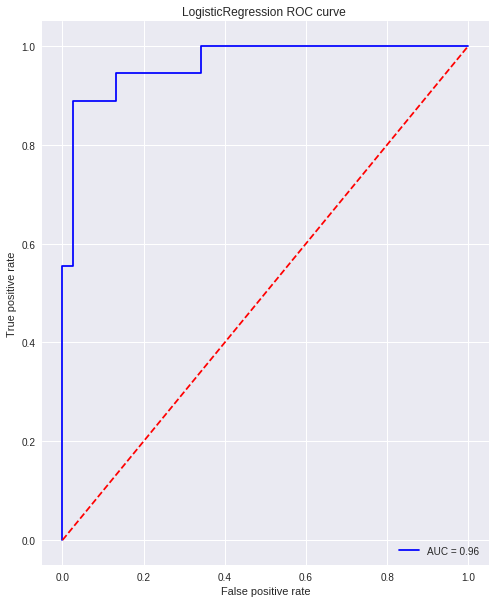

In [46]:
threshold = plot_roc(model_lr, Xtest, Ytest)

### The confusion matrix

In [0]:
# The confusion matrix helps visualize the performance of the algorithm.
y_pred = model_SVC.predict(Xtest)
cm = metrics.confusion_matrix(Ytest, y_pred)
#print(cm)

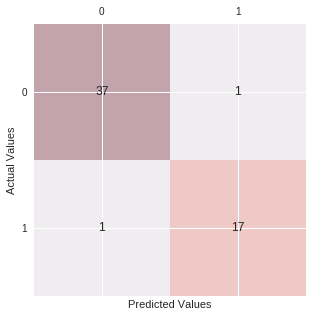

              precision    recall  f1-score   support

          -1       0.97      0.97      0.97        38
           1       0.94      0.94      0.94        18

   micro avg       0.96      0.96      0.96        56
   macro avg       0.96      0.96      0.96        56
weighted avg       0.96      0.96      0.96        56



In [43]:
from IPython.display import Image, display

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()
print(classification_report(Ytest, y_pred ))

### Gradient Boosting Classifier

In [44]:
model=GradientBoostingClassifier()

param_grid = [
    {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
]
Classification_model_gridsearchCV(model,param_grid,Xtrain,Ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameter found on development set is :
{'criterion': 'mae', 'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.13636363636363638, 'min_samples_split': 0.3545454545454546, 'n_estimators': 10, 'subsample': 0.95}
the bset estimator is 
GradientBoostingClassifier(criterion='mae', init=None, learning_rate=0.15,
              loss='deviance', max_depth=3, max_features='log2',
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None,
              min_samples_leaf=0.13636363636363638,
              min_samples_split=0.3545454545454546,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.95, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
The best score is 
0.7222222222222222


In [53]:
model_gbc = GradientBoostingClassifier(loss='deviance', learning_rate=.15, min_samples_split=.354545, min_samples_leaf=.1363636, max_depth=3, max_features='log2', criterion='mae', subsample=.95, n_estimators=100)
model_gbc.fit(Xtrain, Ytrain)
# model_gbc.score(Xtest, Ytest)
# roc_auc_score(Ytest, model_gbc.decision_function(Xtest))
scores = cross_val_score(estimator=model_gbc, X=Xtest, y=Ytest, cv=7)
scores

array([0.66666667, 0.88888889, 0.66666667, 0.5       , 0.85714286,
       0.71428571, 0.85714286])

AUC score: 0.663743 


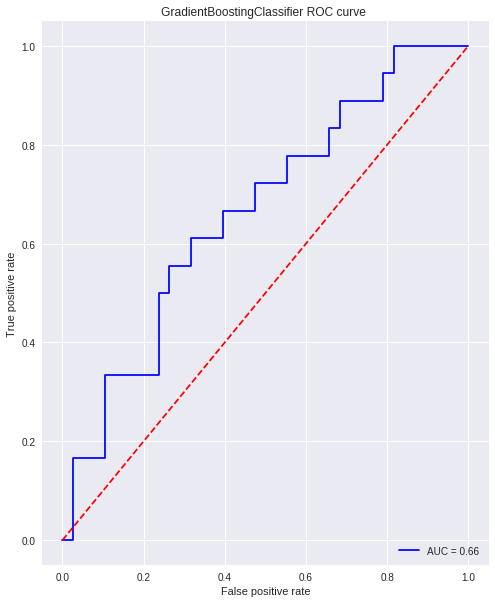

In [54]:
threshold = plot_roc(model_gbc, Xtest, Ytest)

### NuSVM

In [56]:
model = NuSVC()

param_grid = [
    {
    "nu": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    }
]
Classification_model_gridsearchCV(model,param_grid,Xtrain,Ytrain)

The best parameter found on development set is :
{'nu': 0.01}
the bset estimator is 
NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, nu=0.01, probability=False,
   random_state=None, shrinking=True, tol=0.001, verbose=False)
The best score is 
0.6203703703703703


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [60]:
model_nusvc = NuSVC(nu=.01, probability='True')
# model_nusvc.fit(Xtrain, Ytrain)
# model_nusvc.score(Xtest, Ytest)
# roc_auc_score(Ytest, model_nusvc.decision_function(Xtest))
scores = cross_val_score(estimator=model_gbc, X=Xtest, y=Ytest, cv=7)
scores

array([0.66666667, 0.88888889, 0.66666667, 0.5       , 0.85714286,
       0.71428571, 0.85714286])

In [62]:
model_nusvc.fit(Xtrain, Ytrain)
threshold = plot_roc(model_nusvc, Xtest, Ytest)

TypeError: ignored

### NuSVC on all Dataset

In [0]:
nusvc_all = NuSVC(nu=0.2, kernel='linear', probability=True)

In [70]:
nusvc_all.fit(x_train_all, y_train_all)

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=-1, nu=0.2, probability=True,
   random_state=None, shrinking=True, tol=0.001, verbose=False)

### DecisionTreeClassifier

In [71]:
param_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'max_features': [81, 91, 101, 107],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 2, 3],
}
# Create a based model
dtc = DecisionTreeClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dtc, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
#Ytrain = ytrain.reshape(len(Ytrain),)
grid_search.fit(Xtrain,Ytrain)
grid_search.best_params_

Fitting 10 folds for each of 396 candidates, totalling 3960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3960 out of 3960 | elapsed:   19.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 70,
 'max_features': 81,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

In [72]:
treeclassifier = DecisionTreeClassifier(max_depth=50, max_features=91, min_samples_leaf=5, min_samples_split=3)
treeclassifier.fit(Xtrain, Ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=91, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Validation score 0.35
--------------------------------------------
test score 0.5357142857142857
--------------------------------------------
AUC score: 0.554825 


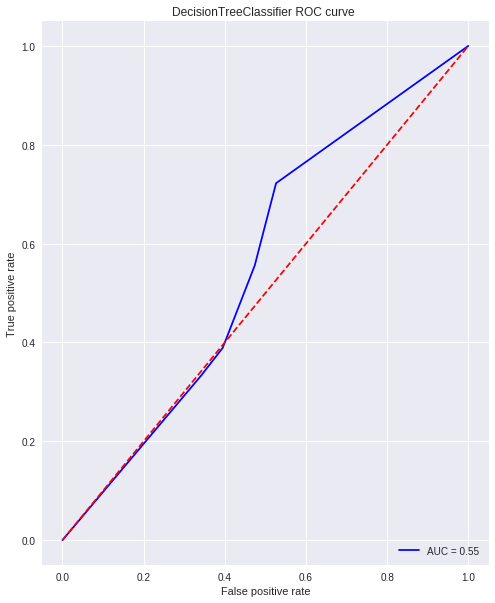

In [73]:
print("Validation score",treeclassifier.score(Xval,Yval))
print("--------------------------------------------")
print("test score",treeclassifier.score(Xtest,Ytest))
print("--------------------------------------------")
threshold = plot_roc(treeclassifier, Xtest, Ytest)

### DecisionTreeClassifier on all Dataset

In [74]:
param_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'max_features': [81, 91, 101, 107],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 2, 3],
}
# Create a based model
dtc_all = DecisionTreeClassifier()
# Instantiate the grid search model
grid_search_all = GridSearchCV(estimator = dtc_all, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
#Ytrain = ytrain.reshape(len(Ytrain),)
grid_search_all.fit(x_train_all, y_train_all)
grid_search_all.best_params_

Fitting 10 folds for each of 396 candidates, totalling 3960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1852 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 3960 out of 3960 | elapsed:   33.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 10,
 'max_features': 101,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

In [75]:
treeclassifier_all = DecisionTreeClassifier(max_depth=10, max_features=87, min_samples_leaf=3, min_samples_split=2)
treeclassifier_all.fit(x_train_all, y_train_all)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=87, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Adaboost Classifier

In [76]:
param_grid_adaboost = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.001, 0.001, 0.01, 0.1, 0.2, 0.5,1]
}
# Create a based model
adaboost = AdaBoostClassifier()
# Instantiate the grid search model
grid_search_adaboost = GridSearchCV(estimator = adaboost, param_grid = param_grid_adaboost, 
                          cv = 10, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
#Ytrain = ytrain.reshape(len(Ytrain),)
grid_search_adaboost.fit(Xtrain,Ytrain)
grid_search_adaboost.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.9min


{'learning_rate': 0.2, 'n_estimators': 500}

In [77]:
adaboost = AdaBoostClassifier(learning_rate=0.5, n_estimators=500)
adaboost.fit(Xtrain, Ytrain)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=500, random_state=None)

Validation score 0.65
--------------------------------------------
test score 0.7857142857142857
--------------------------------------------
AUC score: 0.730994 


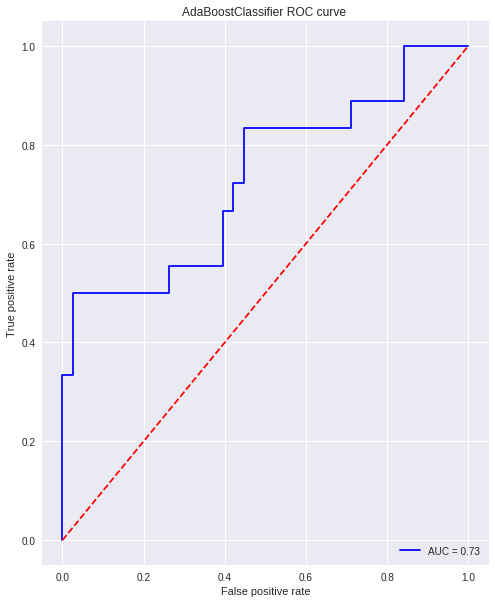

In [78]:
print("Validation score",adaboost.score(Xval,Yval))
print("--------------------------------------------")
print("test score",adaboost.score(Xtest,Ytest))
print("--------------------------------------------")
threshold = plot_roc(adaboost, Xtest, Ytest)

### Adaboost Classifier on all Dataset

In [79]:
param_grid_adaboost = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.001, 0.001, 0.01, 0.1, 0.2, 0.5,1]
}
# Create a based model
adaboost_all = AdaBoostClassifier()
# Instantiate the grid search model
grid_search_adaboost_all = GridSearchCV(estimator = adaboost_all, param_grid = param_grid_adaboost, 
                          cv = 10, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
#Ytrain = ytrain.reshape(len(Ytrain),)
grid_search_adaboost_all.fit(x_train_all, y_train_all)
grid_search_adaboost_all.best_params_

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  5.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.5, 'n_estimators': 1000}

In [80]:
adaboost_all = AdaBoostClassifier(learning_rate=1, n_estimators=200)
adaboost_all.fit(x_train_all, y_train_all)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=200, random_state=None)

### Linear Discriminant Analysis

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
LDA.fit(Xtrain, Ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

Validation score 0.6
--------------------------------------------
test score 0.625
--------------------------------------------
AUC score: 0.657895 


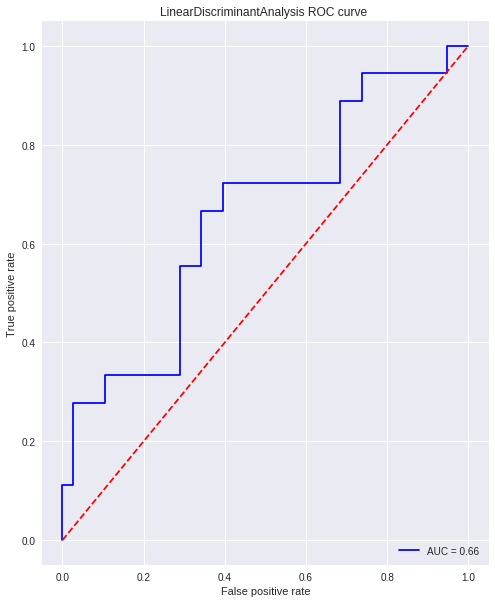

In [82]:
print("Validation score",LDA.score(Xval,Yval))
print("--------------------------------------------")
print("test score",LDA.score(Xtest,Ytest))
print("--------------------------------------------")
threshold = plot_roc(LDA, Xtest, Ytest)

### Linear Discriminant Analysis on all dataset

In [83]:
LDA_all = LinearDiscriminantAnalysis()
LDA_all.fit(x_train_all, y_train_all)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

### Voting

In [0]:
from sklearn.ensemble import VotingClassifier
ensemble=VotingClassifier(estimators=[('Logreg', logreg2),('Logregcv', logregcv), ('SVM', svcmodel),
                                       ('clf', clf),  
                                      ('ada', adaboost),  ('Nusvm', nusvc)], 
                       voting='soft', weights=[3,3,4,2,2,4]).fit(Xtrain,Ytrain)

In [85]:
print('The accuracy is:',ensemble.score(Xtest,Ytest))

The accuracy is: 0.9285714285714286


AUC score: 0.967836 


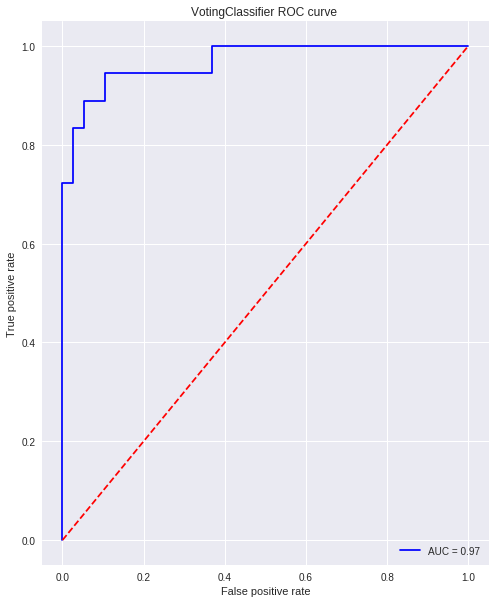

In [86]:
threshold = plot_roc(ensemble, Xtest, Ytest)

In [0]:
# The confusion matrix helps visualize the performance of the algorithm.
y_pred1 = ensemble.predict(Xtest)
cm1 = metrics.confusion_matrix(Ytest, y_pred1)
#print(cm)

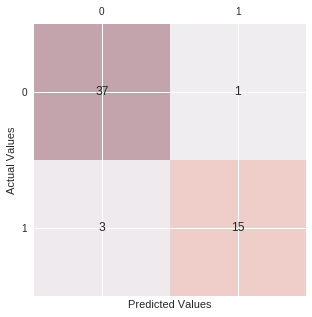

              precision    recall  f1-score   support

          -1       0.93      0.97      0.95        38
           1       0.94      0.83      0.88        18

   micro avg       0.93      0.93      0.93        56
   macro avg       0.93      0.90      0.92        56
weighted avg       0.93      0.93      0.93        56



In [88]:
from IPython.display import Image, display

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm1, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm1.shape[0]):
     for j in range(cm1.shape[1]):
        ax.text(x=j, y=i,
                s=cm1[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()
print(classification_report(Ytest, y_pred1 ))

### Voting on all dataset

In [89]:
ensemble_all=VotingClassifier(estimators=[('Logreg', logreg2_all),('Logregcv', logregcv_all), ('SVM', svcmodel_all),
                                      ('KNN', knnmodel_all), ('clf', clf_all), ('tree', treeclassifier_all), 
                                      ('ada', adaboost_all), ('lda', LDA_all), ('Nusvm', nusvc_all)], 
                       voting='soft', weights=[3,3,4,1,2,1,2,2,4]).fit(x_train_all, y_train_all)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### Prediction on xtest

In [0]:
x_test = xtest.T[good_features]
x_test = x_test.T

In [91]:
import collections
n = 0
predicts = {}
for i in range(len(x_test)):
    if(ensemble.predict_proba(x_test)[i][1] > 0.5):
        n += 1
    print('sample'+str(i+1),'--------------------------------->', ensemble.predict_proba(x_test)[i][1])
print(n)

sample1 ---------------------------------> 0.07307302486704646
sample2 ---------------------------------> 0.44008509970070137
sample3 ---------------------------------> 0.08030005945753443
sample4 ---------------------------------> 0.625497454261844
sample5 ---------------------------------> 0.5485535327851875
sample6 ---------------------------------> 0.07027397570879995
sample7 ---------------------------------> 0.09028635526440291
sample8 ---------------------------------> 0.1276774782944424
sample9 ---------------------------------> 0.7039237726918457
sample10 ---------------------------------> 0.23715440030703488
sample11 ---------------------------------> 0.9044145251549887
sample12 ---------------------------------> 0.33668177448973663
sample13 ---------------------------------> 0.2140712574357577
sample14 ---------------------------------> 0.10656643059813817
sample15 ---------------------------------> 0.7341035111534996
sample16 ---------------------------------> 0.15150604683

### Prediction on xtest using all dataset

In [92]:
n1 = 0
for i in range(len(xtest)):
    if(ensemble.predict_proba(x_test)[i][1] > 0.5):
        n1 += 1
    print('sample'+str(i+1),'--------------------------------->', ensemble.predict_proba(x_test)[i][1])
print(n1)  

sample1 ---------------------------------> 0.07307302486704646
sample2 ---------------------------------> 0.44008509970070137
sample3 ---------------------------------> 0.08030005945753443
sample4 ---------------------------------> 0.625497454261844
sample5 ---------------------------------> 0.5485535327851875
sample6 ---------------------------------> 0.07027397570879995
sample7 ---------------------------------> 0.09028635526440291
sample8 ---------------------------------> 0.1276774782944424
sample9 ---------------------------------> 0.7039237726918457
sample10 ---------------------------------> 0.23715440030703488
sample11 ---------------------------------> 0.9044145251549887
sample12 ---------------------------------> 0.33668177448973663
sample13 ---------------------------------> 0.2140712574357577
sample14 ---------------------------------> 0.10656643059813817
sample15 ---------------------------------> 0.7341035111534996
sample16 ---------------------------------> 0.15150604683

In [93]:
pred.to_csv('predictions.csv', index=False)

NameError: ignored